Imports

In [77]:
import warnings

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
warnings.simplefilter(action="ignore", category=FutureWarning)

Data Preparation

In [38]:
def prep(filepath):
    df = pd.read_csv(filepath)
    
    mask = df["address"].notna()
    maskloc = df["locality"].isin(["San Jose", "Santa Cruz", "San Diego"])
    
    df["price"] = df["price"].replace("Ask for Price", np.nan)
    df = df.dropna(subset=["price"])

    df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)
    maskp = df["price"] < 2500000
  
    df = df[mask & maskloc & maskp]

    df["floor_size_sq_ft"] = df["floor_size_sq_ft"].str.replace(",", "").astype(float)
    
    low, high = df["floor_size_sq_ft"].quantile([0.1, 0.9])
    maskarea = df["floor_size_sq_ft"].between(low, high)
    df = df[maskarea]
    
    #df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    #df.drop(columns = "lat-lon", inplace = True)
    
    #df["neighborhood"] = df["name"].str.split(",", expand=True).str[-1].str.strip()
    
    #df.drop(columns="name", inplace = True)
    
    df.drop(columns=["region", "postal_code"], inplace = True)
    
    df.drop(columns=["link", "locality", "images", "scraped_at", "uniq_id"], inplace = True)
    
    #df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2'], inplace = True)
    
    df.drop(columns=['name', 'description', 'bedrooms', 'bathrooms'], inplace = True)
    
    return df

In [39]:
df = prep("data/homes_dot_com_properties_dataset.csv")
print("df shape:", df.shape)
df.head()

df shape: (15, 5)


C:\Users\USER\AppData\Local\Temp\ipykernel_440\1811215952.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask & maskloc & maskp]


,price,address,latitude,longitude,floor_size_sq_ft
0,816480.0,10125 Baffin Dr,32.900981,-117.153876,1134.0
9,835596.0,8801 Haveteur Way,32.807714,-117.139024,1344.0
10,636160.0,5887 El Zuparko Dr 1,37.245969,-121.865185,1056.0
12,1296813.0,640 Graham Hill Rd,36.998782,-122.029247,1612.0
15,967958.0,1833 Arroyo De Platina,37.358940,-121.855196,1005.0


In [34]:
df.isnull().sum()/len(df)
#df.select_dtypes("object").head()
#df.select_dtypes("object").nunique()

name                0.0
price               0.0
address             0.0
latitude            0.0
longitude           0.0
description         0.0
floor_size_sq_ft    0.0
dtype: float64

Correlation

<Axes: >

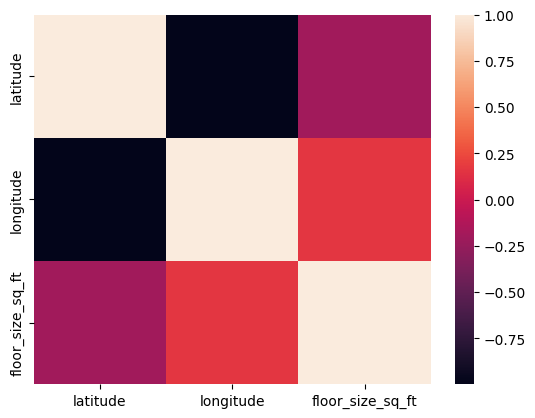

In [36]:
corr = df.select_dtypes("number").drop(columns="price").corr()
sns.heatmap(corr)

Split Data

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 176
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             15 non-null     float64
 1   address           15 non-null     object 
 2   latitude          15 non-null     float64
 3   longitude         15 non-null     float64
 4   floor_size_sq_ft  15 non-null     float64
dtypes: float64(4), object(1)
memory usage: 720.0+ bytes


In [52]:
target = "price"
features = ["floor_size_sq_ft", "latitude", "longitude", "address"]

y = df[target]
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12, 4)
y_train shape: (12,)
X_test shape: (3, 4)
y_test shape: (3,)


In [53]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean price: 796382.67
Baseline MAE: 196667.33333333334


Iterate

In [55]:
linear_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LinearRegression()
)

forest_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, random_state=42)
)

xgboost_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
)

model = VotingRegressor(
    estimators=[
        ('linear', linear_model),
        ('random_forest', forest_model),
        ('xgboost', xgboost_model)
    ]
)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [56]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4055673977.405646


In [57]:
mse = 4055673977.405646
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 63684.17368079487


In [60]:
y_pred = model.predict(X_test)

r2_model = r2_score(y_test, y_pred)
print("R-squared (Model):", r2_model)

# to-%
accuracy_percentage = r2_model * 100
print("Percentage Accuracy for Model:", accuracy_percentage)

R-squared (Model): 0.7489930076388203
Percentage Accuracy for Model: 74.89930076388202


Re-Train

In [69]:
categorical_features = ['address']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' 

)
model = RandomForestRegressor(random_state=42)

# Create a pipeline with preprocessor and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                ('model', model)]
                                )


pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['address'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [70]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

model = RandomForestRegressor(random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score (MSE):", -grid_search.best_score_)

Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best score (MSE): 46008896179.124725


In [72]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

accuracy_percentage = r2 * 100
print("Percentage accuracy for retrained model:", accuracy_percentage)

R-squared: 0.7699449257965033
Percentage accuracy for retrained model: 76.99449257965033


Results

In [75]:
def make_prediction(area, latitude, longitude, address):
    data = {
        "floor_size_sq_ft": area,
        "latitude": latitude,
        "longitude": longitude,
        "address": address
    }
    df = pd.DataFrame(data, index=[0])
    prediction = best_model.predict(df).round(2)[0]
    return f"Predicted price: ${prediction}"

In [76]:
make_prediction(1344.0, 32.807714,-117.139024, "8801 Haveteur Way")

'Predicted price: $780031.37'

In [78]:
filename = 'best_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)


In [79]:
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

In [80]:
y_pred = loaded_model.predict(X_test)